In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as lin
# import seaborn as sn

In [2]:
df_RV = pd.read_table('spilloverdatastocksRV.txt',
                      header=None, names=['A', 'B', 'C'])

In [3]:
df_RV.index = np.arange(1, len(df_RV) + 1)

### Data Description
###### Daily Data of 3 stocks, Realised Variances

Realised variances, RV<sup>+</sup> and RV<sup>-</sup> → Spillover Asymmetry Measure (SAM)

In [232]:
def VAR_Spillover_table_directional(data, H, k):
    N, vars = np.shape(data)
    x = np.ones((N-k, 1))
#     data = data.to_numpy(copy=True)
    data1 = data

    for i in range((k - 1), -1,-1):
        x = np.concatenate((x, trimr(data1, i, k - i)), axis=1)

    x = x[:, 0:(vars * k + 1)]
#     print(x)
#     print(x.shape)
    b = lin.lstsq(x, trimr(data1, k, 0))[0]
#     print(b)
    b = b.T
#     print(b)
    # VMA representation H

    Phi = np.zeros((vars, vars*(H + 1)))
    Phi[0:vars, 0:vars] = np.eye(vars)
#     print(Phi.shape)
#  verify matrix multiplications
    for i in range(0, k):
        for j in range(0, i+1):
            A = Phi[0:vars, 0+(i)*vars:vars + (i)*vars]
            B = (b[0:vars, (0+(j )*vars + 1):vars + (j )*vars + 1])
            C = Phi[0:vars, (0+ (i - j)*vars):vars + (i - j )*vars]
#             print(A.shape, B.shape, C.shape)
            Phi[0:vars, 0+(i)*vars:vars + (i)*vars] =  A + np.dot(B,C)
    for i in range((k ), H):
        for j in range(0, k):
            A = Phi[0:vars, ((i)*vars):(vars + (i)*vars)] 
            B = b[0:vars, ((j ) * vars) + 1:vars + (j ) * vars + 1] 
            C = Phi[0:vars, ((i - j) * vars):vars + (i - j) * vars]
#             print(A.shape, B.shape, C.shape,(i,j))
            Phi[0:vars, 0+(i)*vars:vars + (i)*vars] =  A+B@C
    v = trimr(data, k, 0) - np.dot(x, b.T)                   # VAR residuals
    vc = np.transpose(v)@v/len(v)
    sigma = np.transpose(np.std(v))
#     print(sigma)
    # sigma=var(v)';

    theta = np.zeros((vars, vars))
    theta0 = np.zeros((vars, vars))
    ee = np.eye((vars))
    for i in range(0, vars):
        for j in range(0, vars):
            theta2 = 0
            theta1 = 0
            for h in range(0, H):
                theta1 = theta1 + (np.transpose(ee[:, i]) @ Phi[0:vars, 0+h * vars:vars + h * vars] @ vc @ ee[:, j]) ** 2
                theta2 = theta2 + (np.transpose(ee[:, i]) @ Phi[0:vars, 0+h * vars:vars + h * vars] @ vc @ np.transpose(Phi[0:vars, 0+h*vars:vars + h*vars])@ee[:, i]) 
            theta0[i][j] = (1/sigma[j]*theta1)/theta2
    thetaden = sum(theta0.T)
    for i in range(0, vars):
        for j in range(0, vars):
            theta[i, j] = theta0[i, j] / thetaden[i]
    return theta

In [5]:
#  
def spilloverG(S_VAR):
    k = np.divide(100*(sum(sum(S_VAR)) - sum(np.diag(S_VAR))), sum(sum(S_VAR)))
    return k

In [121]:
def spilloverGfrom(S_VAR):
    k = np.dot(100*(sum(S_VAR.T).T - np.diag(S_VAR.T)),lin.pinv(sum(sum(S_VAR))))
    return k.T

In [57]:
def spilloverGto(S_VAR):
    k = np.divide(100*((sum(S_VAR).T) - np.diag(S_VAR.T)), sum(sum(S_VAR)))
    return k.T

In [8]:
def spilloverGnetpair(S_VAR):
    k = 100*(S_VAR[j,i])/sum(sum(S_VAR)) - S_VAR[i,j]/sum(sum(S_VAR))
    return k

In [9]:
H, lags = 10, 2

In [10]:
T, vars = df_RV.shape

In [104]:
def trimr(x, rb, re):
    # 
#  Returns a matrix (or vector) stripped of the specified rows
# 
#    Inputs:
#              x  = input matrix (or vector) (n x k)
#              rb = first n1 rows to strip
#              re = last  n2 rows to strip
# 
#   Mimics the Gauss routine.
# 
    n = len(x)
    if (rb+re) >= n:
        raise ValueError('Attempting to trim too much')
    z = x[rb: n-re:]
    return z

In [44]:
spill_G = np.empty((T-199, 1,))
spill_Gfrom = np.empty((T-199, 3))
spill_Gto = np.empty((T-199, 3))
spill_Gnetpair = np.empty((T-199, 6))

In [58]:
for t in range(0, T-199):
    S_VAR_table_G = VAR_Spillover_table_directional(df_RV.iloc[t:t+199, :], H, lags)
#     print('check_1')
#     S_VAR_table
#     print(spilloverGfrom(t, S_VAR_table_G))
#     break
#  sum rows
    spill_G[t] = spilloverG(S_VAR_table_G)
    spill_Gfrom[t, :] = spilloverGfrom(S_VAR_table_G)
#  sum columns
    spill_Gto[t, :] = spilloverGto(S_VAR_table_G)
    c = -1
    for i in range(0, vars):
        for j in range(0, vars):
            if i != j:
                c += 1
                spill_Gnetpair[t, c] = spilloverGnetpair(S_VAR_table_G)

<ipython-input-4-da6918f2cb24>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = lin.lstsq(x, trimr(data1, k, 0))[0]


In [71]:
spilloversGnet = np.subtract(spill_Gfrom, spill_Gto)

### Spillovers from Negative Semivariance

In [81]:
df_RVn = pd.read_table('spilloverdatastocksRVn.txt',
                      header=None, names=['A', 'B', 'C'])
spill_Gn = np.empty((T-199, 1,))
spill_Gfromn = np.empty((T-199, 3))
spill_Gton = np.empty((T-199, 3))
spill_Gnetpairn = np.empty((T-199, 6))

In [82]:
for t in range(0, T-199):
    S_VAR_table_G = VAR_Spillover_table_directional(df_RVn.iloc[t:t+199, :], H, lags)
#     print('check_1')
#     S_VAR_table
#     print(spilloverGfrom(t, S_VAR_table_G))
#     break
#  sum rows
    spill_Gn[t] = spilloverG(S_VAR_table_G)
    spill_Gfromn[t, :] = spilloverGfrom(S_VAR_table_G)
#  sum columns
    spill_Gton[t, :] = spilloverGto(S_VAR_table_G)
    c = -1
    for i in range(0, vars):
        for j in range(0, vars):
            if i != j:
                c += 1
                spill_Gnetpairn[t, c] = spilloverGnetpair(S_VAR_table_G)

<ipython-input-4-da6918f2cb24>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = lin.lstsq(x, trimr(data1, k, 0))[0]


In [84]:
spilloversGnetn = spill_Gfromn - spill_Gton

#### Spillovers from Positive Semivariance

In [88]:
df_RVp = pd.read_table('spilloverdatastocksRVp.txt',
                      header = None, names = ['A', 'B', 'C'])
spill_Gp = np.empty((T-199, 1,))
spill_Gfromp = np.empty((T-199, 3))
spill_Gtop = np.empty((T-199, 3))
spill_Gnetpairp = np.empty((T-199, 6))

In [89]:
for t in range(0, T-199):
    S_VAR_table_G = VAR_Spillover_table_directional(df_RVp.iloc[t:t+199, :], H, lags)
#     print('check_1')
#     S_VAR_table
#     print(spilloverGfrom(t, S_VAR_table_G))
#     break
#  sum rows
    spill_Gp[t] = spilloverG(S_VAR_table_G)
    spill_Gfromp[t, :] = spilloverGfrom(S_VAR_table_G)
#  sum columns
    spill_Gtop[t, :] = spilloverGto(S_VAR_table_G)
    c = -1
    for i in range(0, vars):
        for j in range(0, vars):
            if i != j:
                c += 1
                spill_Gnetpairp[t, c] = spilloverGnetpair(S_VAR_table_G)

<ipython-input-4-da6918f2cb24>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = lin.lstsq(x, trimr(data1, k, 0))[0]


In [91]:
spilloversGnetp = spill_Gfromp - spill_Gtop

##### Spillover for financial stocks

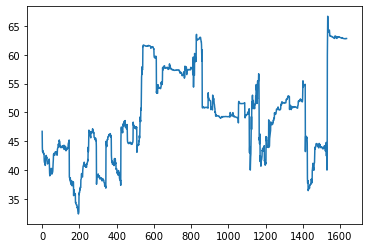

In [100]:
plt.plot(spill_G)

##### SAM for the finacial stocks

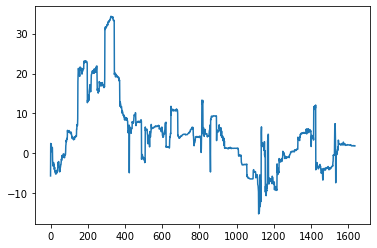

In [101]:
plt.plot(spill_Gp - spill_Gn)

##### Bank Of America SAM-To

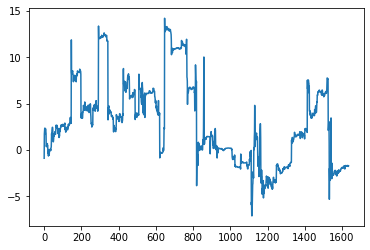

In [115]:
plt.plot(spill_Gtop[:,0] - spill_Gton[:,0])

##### Citigroup SAM To

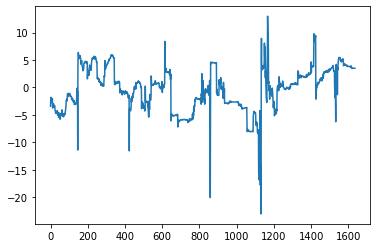

In [116]:
plt.plot(spill_Gtop[:, 1] - spill_Gton[:, 1])

##### Wells Fargo SAM To

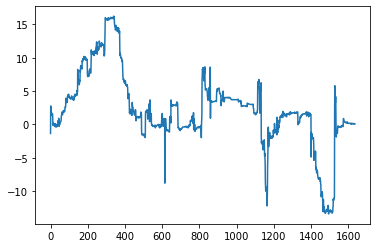

In [117]:
plt.plot(spill_Gtop[:,2] - spill_Gton[:,2])

###### Bank OF America SAM From

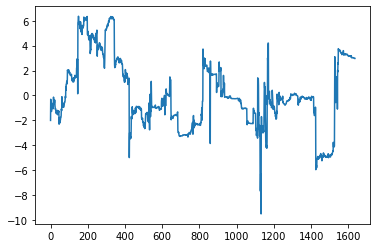

In [118]:
plt.plot(spill_Gfromp[:,0] - spill_Gfromn[:,0])

 ##### Citigroup SAM From

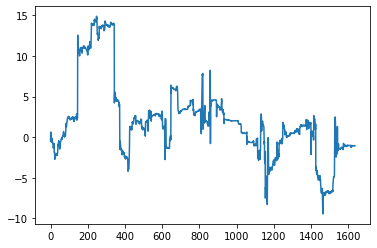

In [119]:
plt.plot(spill_Gfromp[:,1] - spill_Gfromn[:, 1])

#####   Wells Fargo SAM From (Higher Resolution figures from here on)

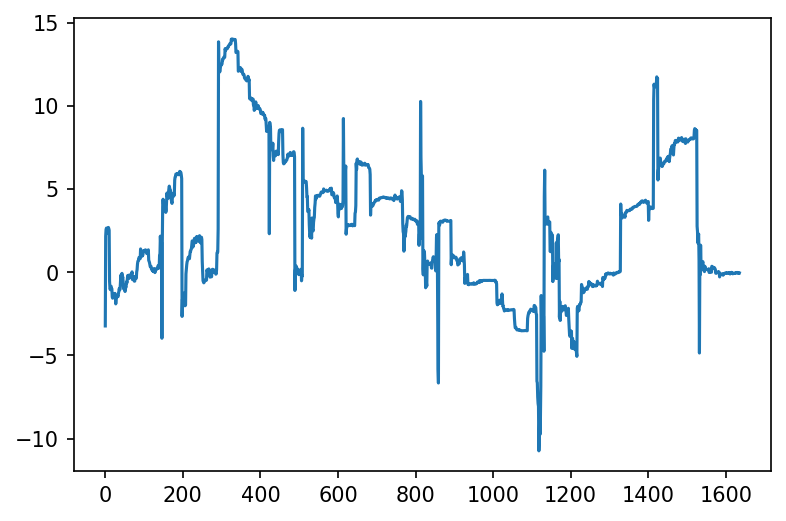

In [283]:
plt.figure(dpi=150)
plt.plot(spill_Gfromp[:, 2] - spill_Gfromn[:, 2])

#### Filled SAM From plots for Bank of America, Citigoup and Wells Fargo (in that order)

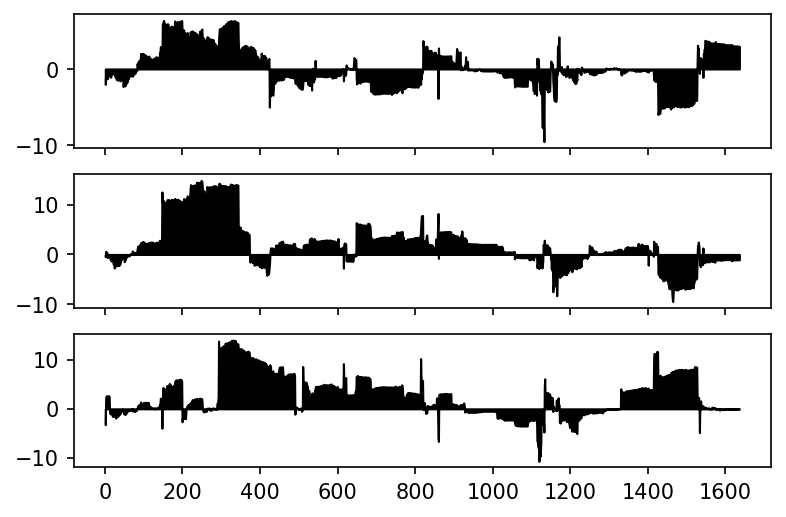

In [285]:
# subplots.figure(dpi = 300)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi = 150)
ax1.fill_between(range(1,1637),0,spill_Gfromp[:,0] - spill_Gfromn[:, 0], color = 'black')
ax2.fill_between(range(1,1637),0,spill_Gfromp[:,1] - spill_Gfromn[:, 1], color = 'black')
ax3.fill_between(range(1,1637),0,spill_Gfromp[:,2] - spill_Gfromn[:, 2], color = 'black')

###### Citigoup SAM from

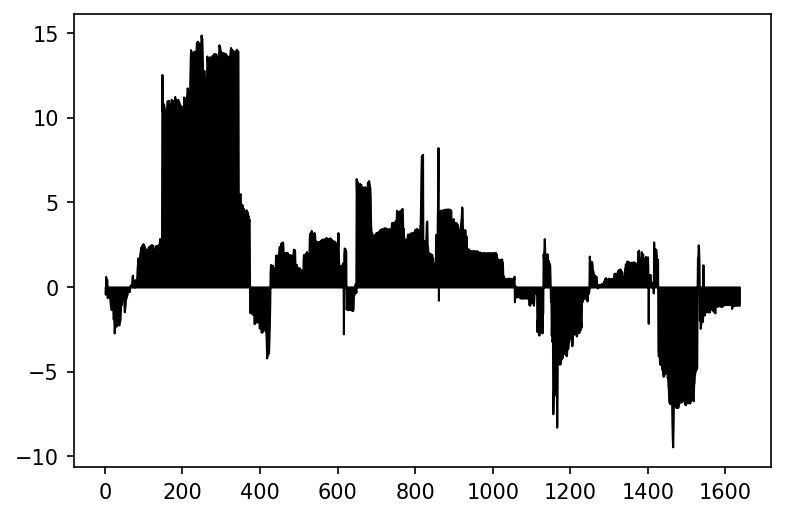

In [280]:
plt.figure(dpi=150)
plt.fill_between(range(1,1637), spill_Gfromp[:,1] - spill_Gfromn[:, 1], color = 'black')

###### Wells Fargo SAM From

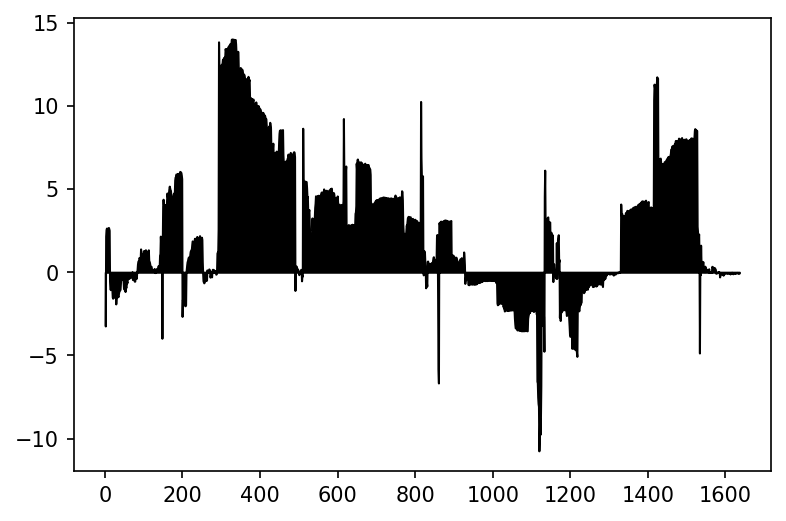

In [281]:
plt.figure(dpi=150)
plt.fill_between(range(1,1637),spill_Gfromp[:,2] - spill_Gfromn[:, 2], color = 'black')